# Matrix Factorization using Tensorflow 2.8.0

Matrix Factorization is one of the most common technique in Collaborative Filtering Recommendation System.

Factorization simply means expressing something big as a product of smaller factors

The idea is to factorize a user and item matrix so it can calculate the rating of an item with much smaller matrix

<img src="https://miro.medium.com/max/500/1*rWjYGlDlzzbAVizBk7nOrw.png" alt="Drawing" style="width: 500px"/>

Imagine N is number of users and M is number of movies (items). Let's say there are 100M users and 10M movies. 

The matrix size before factorization is 100M * 10M = 1,000,000B!

If we Factorize it into 10 features (latent features), it will reduce the matrix size to 100M * 10 + 10M * 10 = 1,100M

These latent features will find the relationship between users matrix and items matrix, so the rating can be calculated using the dot product of user matrix and item matrix

#### Great Resources:
- https://medium.com/sfu-cspmp/recommendation-systems-collaborative-filtering-using-matrix-factorization-simplified-2118f4ef2cd3
- https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b
- https://medium.com/@yashsonar213/how-to-build-a-recommendation-systems-matrix-factorization-using-keras-778931cc666f (Some code referring to this tutorial)
- https://www.youtube.com/watch?v=G4MBc40rQ2k (Some code referring to this tutorial)

## Download Data
https://grouplens.org/datasets/movielens/

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

    F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872


In [1]:
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1788k      0 --:--:-- --:--:-- --:--:-- 1785k


In [2]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

## Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.layers import Embedding, Flatten, Dense, dot

physical_devices = tf.config.list_physical_devices("GPU")
physical_devices

tf.random.set_seed(0)

In [4]:
tf.__version__

'2.8.0'

## Load Data

In [5]:
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


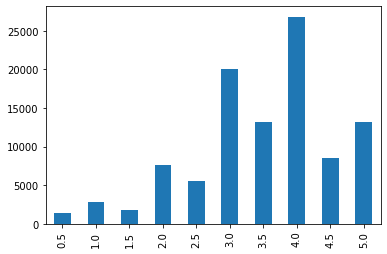

In [7]:
ratings_df['rating'].value_counts().sort_index().plot(kind='bar')

In [8]:
ratings_df['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [9]:
percentage_ratings = ratings_df['rating'].value_counts(normalize=True).sort_index()
percentage_ratings[percentage_ratings.index >= 4].sum()

0.4817723828791305

Almost 50% of the ratings are greater than 4 stars

In [10]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [12]:
print('Movies shape: ', movies_df.shape)
print('Ratings shape: ', ratings_df.shape)

Movies shape:  (9742, 3)
Ratings shape:  (100836, 4)


In [13]:
n_users = len(ratings_df.userId.unique())
n_items = len(ratings_df.movieId.unique())

print("Number of unique users:", n_users)
print("Number of unique movies:", n_items)
print("The full rating matrix will have:", n_users*n_items, 'elements.')
print('----------')
print("Number of ratings:", len(ratings_df))
print("Therefore, only ", len(ratings_df) / (n_users*n_items) * 100, '% of the matrix is filled (Sparse Matrix).')

Number of unique users: 610
Number of unique movies: 9724
The full rating matrix will have: 5931640 elements.
----------
Number of ratings: 100836
Therefore, only  1.6999683055613624 % of the matrix is filled (Sparse Matrix).


Only 1.6% matrix is filled, because in reality a user only watches a small number of movies.

The latent factors will study from the existing relationship and can fill even the unwatched movies for all users.

## Defining Keras Model via Subclassing

In [14]:
N_LATENT_FACTORS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 100

In [15]:
class MatrixFactorization(keras.Model):
    def __init__(self, n_users, n_items, n_latent_factors=10):
        super(MatrixFactorization, self).__init__()

        self.user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')
        self.item_embedding = Embedding(n_items, n_latent_factors, name='item_embedding')
        self.flatten = Flatten()
        self.predictor = Dense(1, activation='relu')

    # feed forward
    def call(self, input_tensor, training=False):
        u = self.user_embedding(input_tensor[0], training=training)
        i = self.item_embedding(input_tensor[1], training=training)

        u = self.flatten(u)
        i = self.flatten(i)

        x = dot([u, i], axes=1)
        x = self.predictor(x, training=training)

        return x

    def model(self):
        user = keras.Input(shape=(1,), name='user_input')
        item = keras.Input(shape=(1,), name='item_input')

        return keras.Model(inputs=[user, item], outputs=self.call([user, item]))

In [16]:
model = MatrixFactorization(n_users, n_items, n_latent_factors=N_LATENT_FACTORS).model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        6100        ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        97240       ['item_input[0][0]']             
                                                                                              

In [17]:
model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(lr=LEARNING_RATE),
    metrics=['mse'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Prepare Data

Making sure the movie ID and user ID starts from 0 and ends in N - 1 (for the embedding to work)

In [18]:
# use rankdata with dense method to make the proper id sequence
stats.rankdata([1,10,20,10], method='dense')

array([1, 2, 3, 2])

In [19]:
# make mapping from real movie id to converted movie id
ratings_df['ranked_movieId'] = stats.rankdata(ratings_df['movieId'], method='dense') - 1

real_to_rank_movieId = {}
for i, content in ratings_df.iterrows():
    real_to_rank_movieId[content['movieId']] = content['ranked_movieId']

In [20]:
# map for movies_df
movies_df['ranked_movieId'] = movies_df['movieId'].map(real_to_rank_movieId)

In [21]:
# also normalizer the userId to start from 0
ratings_df['userId'] = ratings_df['userId'] - 1

In [22]:
assert ratings_df['ranked_movieId'].min() == 0
assert ratings_df['ranked_movieId'].max() == (n_items-1)

assert ratings_df['userId'].min() == 0
assert ratings_df['userId'].max() == (n_users-1)

In [23]:
# drop movie rows that don't have rating
movies_df = movies_df.dropna()

In [24]:
def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    # Only allows for equal validation and test splits
    assert val_split == test_split 

    # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(train_split * len(df)), int((1 - val_split) * len(df))]
    
    train_df, val_df, test_df = np.split(df_sample, indices_or_sections)
    
    return train_df, val_df, test_df

In [25]:
train_df, val_df, test_df = get_dataset_partitions_pd(ratings_df)

## Training

In [26]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0, 
    patience=5, 
    verbose=0,
    mode='auto',
    restore_best_weights=True
)

history = model.fit(
    x = [train_df['userId'].values,train_df['ranked_movieId'].values],
    y = train_df['rating'].values,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data = (
        [val_df['userId'].values,val_df['ranked_movieId'].values],
        val_df['rating'].values
    ),
    callbacks=[early_stop_cb],
)

Epoch 1/100
631/631 [==============================] - 7s 7ms/step - loss: 10.9434 - mse: 10.9434 - val_loss: 6.9781 - val_mse: 6.9781
Epoch 2/100
631/631 [==============================] - 4s 6ms/step - loss: 3.0928 - mse: 3.0928 - val_loss: 1.7404 - val_mse: 1.7404
Epoch 3/100
631/631 [==============================] - 3s 5ms/step - loss: 1.2724 - mse: 1.2724 - val_loss: 1.2355 - val_mse: 1.2355
Epoch 4/100
631/631 [==============================] - 3s 5ms/step - loss: 0.9374 - mse: 0.9374 - val_loss: 1.0753 - val_mse: 1.0753
Epoch 5/100
631/631 [==============================] - 3s 4ms/step - loss: 0.7980 - mse: 0.7980 - val_loss: 1.0055 - val_mse: 1.0055
Epoch 6/100
631/631 [==============================] - 2s 3ms/step - loss: 0.7212 - mse: 0.7212 - val_loss: 0.9712 - val_mse: 0.9712
Epoch 7/100
631/631 [==============================] - 2s 3ms/step - loss: 0.6712 - mse: 0.6712 - val_loss: 0.9512 - val_mse: 0.9512
Epoch 8/100
631/631 [==============================] - 2s 3ms/step 

In [27]:
model.evaluate([val_df['userId'], val_df['ranked_movieId']], val_df['rating'], batch_size=128, verbose=2)
# [0.9323457479476929, 0.9323457479476929]

79/79 - 0s - loss: 0.9323 - mse: 0.9323 - 238ms/epoch - 3ms/step


[0.9323457479476929, 0.9323457479476929]

In [28]:
model.evaluate([test_df['userId'], test_df['ranked_movieId']], test_df['rating'], batch_size=128, verbose=2)

79/79 - 0s - loss: 0.9356 - mse: 0.9356 - 137ms/epoch - 2ms/step


[0.9356298446655273, 0.9356298446655273]

In [29]:
movies_df

,movieId,title,genres,ranked_movieId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.0
2,3,Grumpier Old Men (1995),Comedy|Romance,2.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.0
4,5,Father of the Bride Part II (1995),Comedy,4.0
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9719.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9720.0
9739,193585,Flint (2017),Drama,9721.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9722.0


## What can we do with the embeddings?
- Generate movie embedding / latent features from the model and cluster them to look for similar movies
- Use the movie embedding to create a user embedding (movie embedding will be obtained by assuming some initial favorite movies for a new user)

The second use case is one of the solution for cold start problem

### Generate movie embedding / latent features from the model and cluster them to look for similar movies

In [30]:
# model to get movie embedding for specific movie id, just take the item layer input and item embedding layer output
movie_embedding_model = keras.Model(inputs=model.get_layer('item_input').input, outputs = model.get_layer('item_embedding').output)

movie_embeddings = movie_embedding_model.predict(movies_df['ranked_movieId'])
movie_embeddings = movie_embeddings.reshape(len(movies_df), 10)

In [31]:
from sklearn.cluster import KMeans

In [32]:
K = range(1, 10)

inertias = []
mapping = {}

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(movie_embeddings)
    inertias.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_

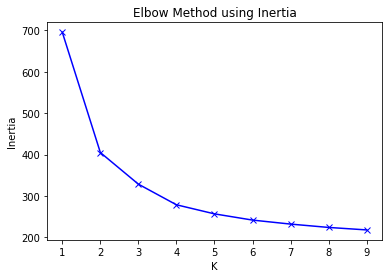

In [33]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method using Inertia')
plt.show()

From the elbow method graph, we can use k = 2/3/4

In [34]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(movie_embeddings)

In [35]:
for cluster in range(4):
  print("Cluster #{}".format(cluster))
  movies = []
  for movie_index in np.where(kmeans.labels_ == cluster)[0]:
      movie_name = movies_df.iloc[movie_index]['title']
      movie_cat = movies_df.iloc[movie_index]['genres']
      movie_id = movies_df.iloc[movie_index]['ranked_movieId']
      movie_rating_count = ratings_df.loc[ratings_df['ranked_movieId'] == movie_id].count()[0]
      movies.append((movie_name, movie_cat, movie_rating_count))

  for movie in sorted(movies, key=lambda x: x[2], reverse=True)[:10]:
      print("\t", movie[0], ' - ', movie[1])

Cluster #0
	 Forrest Gump (1994)  -  Comedy|Drama|Romance|War
	 Jurassic Park (1993)  -  Action|Adventure|Sci-Fi|Thriller
	 Braveheart (1995)  -  Action|Drama|War
	 Toy Story (1995)  -  Adventure|Animation|Children|Comedy|Fantasy
	 Independence Day (a.k.a. ID4) (1996)  -  Action|Adventure|Sci-Fi|Thriller
	 Apollo 13 (1995)  -  Adventure|Drama|IMAX
	 Fugitive, The (1993)  -  Thriller
	 True Lies (1994)  -  Action|Adventure|Comedy|Romance|Thriller
	 Lion King, The (1994)  -  Adventure|Animation|Children|Drama|Musical|IMAX
	 Speed (1994)  -  Action|Romance|Thriller
Cluster #1
	 Austin Powers: The Spy Who Shagged Me (1999)  -  Action|Adventure|Comedy
	 Natural Born Killers (1994)  -  Action|Crime|Thriller
	 Charlie's Angels (2000)  -  Action|Comedy
	 Honey, I Shrunk the Kids (1989)  -  Adventure|Children|Comedy|Fantasy|Sci-Fi
	 Austin Powers in Goldmember (2002)  -  Comedy
	 Blair Witch Project, The (1999)  -  Drama|Horror|Thriller
	 Pleasantville (1998)  -  Comedy|Drama|Fantasy
	 Charlie 

- The cluster 0 contains mostly with Adventure | Action movies
- The cluster 1 contains mostly with Action | Comedy movies
- The cluster 2 contains mostly with Action | Sci-Fi | Thriller movies
- The cluster 3 contains OG Crime and Thriller Movies, such as Shawshank, Pulp Fiction, Silence of the Lambs, Schindler's List, Fight Club, The Usual Suspects


## Use the movie embedding to create a user embedding

New users will be asked what their favorite movie category is, and the system will pick random popular movies based for the initial bias movie

Assuming the new user likes Animation category

In [36]:
# assuming the more people rated for a movie, the more popular the movie is
ratings_counter = ratings_df.groupby('ranked_movieId').count().iloc[:,:1]
ratings_counter.columns = ['count']
ratings_counter = ratings_counter.reset_index()
movies_df_withcount = movies_df.merge(ratings_counter, left_on='ranked_movieId', right_on='ranked_movieId', how='left')

In [37]:
movies_df_withcount =  movies_df_withcount.fillna(0.0)

In [38]:
# taking 5 random popular animation movies
movies_df_withcount[
    (movies_df_withcount['genres'].str.contains('Animation'))
].sort_values('count', ascending=False)[:100].sample(10, random_state=0)

,movieId,title,genres,ranked_movieId,count
1543,2080,Lady and the Tramp (1955),Animation|Children|Comedy|Romance,1543.0,55
1594,2137,Charlotte's Web (1973),Animation|Children,1594.0,21
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,322.0,172
2996,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,2996.0,37
1794,2394,"Prince of Egypt, The (1998)",Animation|Musical,1794.0,25
3225,4366,Atlantis: The Lost Empire (2001),Adventure|Animation|Children|Fantasy,3225.0,19
3740,5218,Ice Age (2002),Adventure|Animation|Children|Comedy,3740.0,85
585,720,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy,585.0,27
4145,5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy,4145.0,37
5805,32031,Robots (2005),Adventure|Animation|Children|Comedy|Fantasy|Sc...,5805.0,19


In [39]:
rand_animation_movie_ids = movies_df_withcount[
    (movies_df_withcount['genres'].str.contains('Animation'))
].sort_values('count', ascending=False)[:100].sample(10, random_state=0)['ranked_movieId'].values

### Use the animation movie ids for building new user embedding

In [40]:
movie_id_new_user = rand_animation_movie_ids.astype(int)

# generate movie embeddings for the movies
user_movie_embeddings = movie_embedding_model.predict(x = movie_id_new_user)
user_movie_embeddings = user_movie_embeddings.reshape(len(movie_id_new_user),10)

# 5 start for all of the picked animation movies
user_movie_bias = np.array([5 for _ in range(len(movie_id_new_user))])

# get user embedding using lstsq (https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)
# we know that: movie_rating = user_embedding @ item_embedding
user_embedding, residuals, rank, s = np.linalg.lstsq(user_movie_embeddings,user_movie_bias, rcond=-1) # Get embedding for new user
user_embedding = user_embedding.reshape(1, 10)

print(user_embedding)

[[-15.69031535  -2.20211383  -2.2600645   -4.37040266   7.52471346
   -6.35338882  10.61555575  16.95897191   4.53357342  -3.58476399]]


In [41]:
# get 20 most popular movies that have the predicted rating >= 4 for this new user
movies_df_withcount[np.sum(user_embedding * movie_embeddings, axis=1) >= 4].sort_values('count',ascending=False)[:20]

,movieId,title,genres,ranked_movieId,count
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,418.0,238
461,527,Schindler's List (1993),Drama|War,461.0,220
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,215
897,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,897.0,211
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,615.0,202
123,150,Apollo 13 (1995),Adventure|Drama|IMAX,123.0,201
899,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,899.0,200
398,457,"Fugitive, The (1993)",Thriller,398.0,190
4131,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,4131.0,188
337,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,337.0,178


There are some animation movies on the top 20 recommendation such as Toy Story, Lion King, and Shrek. Combining the matrix factorization with neural nets will make the rating prediction better

Another idea is to create user_embedding_model and find similar users with this new user and give movie recommendation based on similar users